## Import

In [1]:
import copy
import numpy as np
from pypfopt import risk_models, exceptions
from pypfopt import EfficientFrontier, CLA
from copy import deepcopy
import scipy.cluster.hierarchy as sch
import warnings

import matplotlib.pyplot as plt

plt.style.use("seaborn-deep")

from pypfopt.expected_returns import mean_historical_return, ema_historical_return, capm_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pypfopt
import pandas as pd
import numpy as np
import datetime
import os

plt.rcParams['font.family']= "gulim"

In [2]:
from collections import OrderedDict
from pyfolio.utils import APPROX_BDAYS_PER_MONTH, MM_DISPLAY_UNIT
from pypfopt.cla import CLA

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from quantrocket.zipline import ZiplineBacktestResult

import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical
import seaborn as sns

* functions

In [4]:
def read_xlsx(name):
    instance = xw.App(visible = False)
    xlsx_data = xw.Book(name).sheets[0]
    df = xlsx_data.range('A1').options(pd.DataFrame, index = False, expand = 'table').value
    instance.quit()
    instance.kill()
    return df

def read_data(name):
    try :
        output = pd.read_excel(name)
    except ValueError:    
        output = read_xlsx(name)
    return output

In [5]:
def get_perf_stats(returns, factor_returns=None, positions=None,
                    transactions=None, turnover_denom='AGB',
                    live_start_date=None, bootstrap=False,
                    header_rows=None):
    if bootstrap:
        perf_func = pf.timeseries.perf_stats_bootstrap
    else:
        perf_func = pf.timeseries.perf_stats
    STAT_FUNCS_PCT = [
        'Annual return',
        'Cumulative returns',
        'Annual volatility',
        'Max drawdown',
        'Daily value at risk',
        'Daily turnover'
    ]

    perf_stats_all = perf_func(
        returns,
        factor_returns=factor_returns,
        positions=positions,
        transactions=transactions,
        turnover_denom=turnover_denom)

    date_rows = OrderedDict()
    if len(returns.index) > 0:
        date_rows['Start date'] = returns.index[0].strftime('%Y-%m-%d')
        date_rows['End date'] = returns.index[-1].strftime('%Y-%m-%d')

    if live_start_date is not None:
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)
        returns_is = returns[returns.index < live_start_date]
        returns_oos = returns[returns.index >= live_start_date]

        positions_is = None
        positions_oos = None
        transactions_is = None
        transactions_oos = None

        if positions is not None:
            positions_is = positions[positions.index < live_start_date]
            positions_oos = positions[positions.index >= live_start_date]
            if transactions is not None:
                transactions_is = transactions[(transactions.index <
                                                live_start_date)]
                transactions_oos = transactions[(transactions.index >
                                                 live_start_date)]

        perf_stats_is = perf_func(
            returns_is,
            factor_returns=factor_returns,
            positions=positions_is,
            transactions=transactions_is,
            turnover_denom=turnover_denom)

        perf_stats_oos = perf_func(
            returns_oos,
            factor_returns=factor_returns,
            positions=positions_oos,
            transactions=transactions_oos,
            turnover_denom=turnover_denom)
        if len(returns.index) > 0:
            date_rows['In-sample months'] = int(len(returns_is) /
                                                APPROX_BDAYS_PER_MONTH)
            date_rows['Out-of-sample months'] = int(len(returns_oos) /
                                                    APPROX_BDAYS_PER_MONTH)

        perf_stats = pd.concat(OrderedDict([
            ('In-sample', perf_stats_is),
            ('Out-of-sample', perf_stats_oos),
            ('All', perf_stats_all),
        ]), axis=1)
    else:
        if len(returns.index) > 0:
            date_rows['Total months'] = int(len(returns) /
                                            APPROX_BDAYS_PER_MONTH)
        perf_stats = pd.DataFrame(perf_stats_all, columns=['Backtest'])

    for column in perf_stats.columns:
        for stat, value in perf_stats[column].iteritems():
            if stat in STAT_FUNCS_PCT:
                perf_stats.loc[stat, column] = str(np.round(value * 100,
                                                            3)) + '%'
    if header_rows is None:
        header_rows = date_rows
    else:
        header_rows = OrderedDict(header_rows)
        header_rows.update(date_rows)
    return perf_stats

## Load data

In [6]:
data_path = os.getcwd() + "\\datasets\\"

stock_df = read_data(data_path + "stock_df.xlsx")
port_input = stock_df.iloc[:, 1:]

In [7]:
#total_df = read_data(data_path + "total_df.xlsx")

In [7]:
if os.path.isfile(data_path + "currency.xlsx"):
    currency = read_data(data_path + "currency.xlsx")

start_date = np.max(currency.Date)

try :
    append_curr = fdr.DataReader("USD/KRW", start = start_date)
    append_curr = append_curr.reset_index()

    currency = currency.loc[currency.Date < start_date, :]
    currency = pd.concat([currency, append_curr])
    currency.index = [x for x in range(currency.shape[0])]
    currency.to_excel(data_path + "currency.xlsx", index = False)

except:
    print("추가행 없음")
    pass

In [8]:
#start_date = '2020-05-23'
start_date = '2015-01-01'

snp_500 = fdr.DataReader('US500', start_date)['Close']
kospi = fdr.DataReader('KS11', start_date)['Close']

snp_500.index = pd.to_datetime(snp_500.index, utc = True)
kospi.index = pd.to_datetime(kospi.index, utc = True)

currency.Date = pd.to_datetime(currency.Date, utc = True)

exchange = currency.loc[currency.Date.isin(snp_500.index)]['Close']
exchange.index = snp_500.index

start_date = pd.to_datetime(start_date, utc = True)
snp_500 *= exchange

In [10]:
'''
bench_snp = snp_500.loc[snp_500.index.isin(pf_returns.index)]
bench_kospi = kospi.loc[kospi.index.isin(pf_returns.index)]
'''

'\nbench_snp = snp_500.loc[snp_500.index.isin(pf_returns.index)]\nbench_kospi = kospi.loc[kospi.index.isin(pf_returns.index)]\n'

* Return 계산하기

In [9]:
def get_return(port_input, opt = 'mean'):
    if opt == 'mean':
        output = mean_historical_return(port_input)
    elif opt == 'ema':
        output = ema_historical_return(port_input)
    elif opt == 'capm':
        output = capm_return(port_input)
    elif opt == "price":
        output = returns_from_prices(port_input)
    return output

In [10]:
mean_return = get_return(port_input, 'mean')
ema_return = get_return(port_input, 'ema')
#capm_return = get_return(port_input, 'capm')
price_return = get_return(port_input, 'price')

* Risk 계산하기

In [11]:
def get_cov(port_input, opt = 'CovarianceShrinkage-01'):
    if opt == 'CovarianceShrinkage-01':
        S = CovarianceShrinkage(port_input).ledoit_wolf()
    elif opt == 'CovarianceShrinkage-02':
        S = CovarianceShrinkage(port_input).shrunk_covariance()
    elif opt == 'CovarianceShrinkage-03':
        S = CovarianceShrinkage(port_input).oracle_approximating()
    elif opt == "exp_cov":
        S = pypfopt.risk_models.exp_cov(port_input)
    elif opt == "semicovariance":
        S = pypfopt.risk_models.semicovariance(port_input)
    return S

In [12]:
cs_01 = get_cov(port_input, opt = 'CovarianceShrinkage-01')
cs_02 = get_cov(port_input, opt = 'CovarianceShrinkage-02')
cs_03 = get_cov(port_input, opt = 'CovarianceShrinkage-03')
S_exp = get_cov(port_input, opt = 'exp_cov')
S_semi = get_cov(port_input, opt = 'semicovariance')

* etf list 정리

In [15]:
etf_df = fdr.StockListing("ETF/KR")
etf_list =[x for x in port_input.columns if x in list(etf_df.Name)]

cate = ["etf" if x in etf_list else "stock" for x in port_input.columns]
sector_dict = {x:y for x,y in zip(port_input.columns, cate)}

get_lower = (0, 0)
get_upper = (0.8, 0.8)

lower_dict = {"etf" : get_lower[0], "stock" : get_lower[1]}
upper_dict = {"etf" : get_upper[0], "stock" : get_upper[1]}

* EfficientFrontier

In [13]:
def mvo(ef, method = "max_sharpe"):
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    elif method == "min_volatility":
        weights = ef.min_volatility()
    elif method == "max_quadratic_utility":
        weights = ef.max_quadratic_utility()
    return weights

In [14]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'max_sharpe')

ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'min_volatility')

ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'max_quadratic_utility')

In [15]:
weights

OrderedDict([('JW중외제약', -2.260784e-10),
             ('KODEX 미국S&P500TR', 2.76723597e-08),
             ('KODEX 코스피TR', -2.8030044e-08),
             ('LG전자', 5.344055e-10),
             ('NAVER', -5.50516e-11),
             ('OCI', 3.681195e-10),
             ('SK바이오사이언스', -5.635436e-10),
             ('SK하이닉스', 1.1436377e-09),
             ('STX', -3.45366e-11),
             ('고려신용정보', 0.9999999990713841),
             ('삼성전자', -1.5491835e-09),
             ('삼천리자전거', 8.947641e-10),
             ('씨티케이', 9.301092e-10),
             ('아프리카TV', -3.171705e-10),
             ('카카오', 6.131628e-10),
             ('카카오페이', -6.026103e-10),
             ('피씨엘', 5.11331e-11),
             ('한탑', 9.89422e-11)])

In [16]:
# (expected return, volatility, sharpe ratio) for the optimized portfolio
ef.portfolio_performance()

(0.34836301668672714, 0.20897920622201224, 1.5712712409189922)

* risk parity optimization

In [17]:
rp = pypfopt.hierarchical_portfolio.HRPOpt(price_return, S_semi)

In [18]:
rp.optimize()

OrderedDict([('JW중외제약', 0.030814525626915928),
             ('KODEX 미국S&P500TR', 0.23446839083920928),
             ('KODEX 코스피TR', 0.11251316619139022),
             ('LG전자', 0.05594144337692882),
             ('NAVER', 0.05186653268806386),
             ('OCI', 0.033033547772208086),
             ('SK바이오사이언스', 0.01752188636104095),
             ('SK하이닉스', 0.04330285216183348),
             ('STX', 0.029557595463871173),
             ('고려신용정보', 0.10282978339641766),
             ('삼성전자', 0.05179501356403697),
             ('삼천리자전거', 0.04465111604969691),
             ('씨티케이', 0.0374350348639816),
             ('아프리카TV', 0.03612253517235156),
             ('카카오', 0.04706368639652183),
             ('카카오페이', 0.015221903053814741),
             ('피씨엘', 0.01751524392314401),
             ('한탑', 0.03834574309857285)])

In [19]:
rp.portfolio_performance()

(0.09366800217026662, 0.1628207984577939, 0.45244835345382917)

* CLA

In [20]:
cla = CLA(mean_return, cs_01, weight_bounds=(0, 1))
cla.max_sharpe()

OrderedDict([('JW중외제약', 0.0),
             ('KODEX 미국S&P500TR', 0.7267524816627884),
             ('KODEX 코스피TR', -2.6603259079577485e-17),
             ('LG전자', 0.0),
             ('NAVER', 0.0),
             ('OCI', 0.0),
             ('SK바이오사이언스', 0.0),
             ('SK하이닉스', 0.0),
             ('STX', 0.0),
             ('고려신용정보', 0.19587533772829943),
             ('삼성전자', 0.0685908850646272),
             ('삼천리자전거', 0.0),
             ('씨티케이', 0.0),
             ('아프리카TV', 0.008781295544285016),
             ('카카오', 0.0),
             ('카카오페이', 0.0),
             ('피씨엘', 0.0),
             ('한탑', 0.0)])

* back testing

In [ ]:
# weights를 기반으로 transactions이 구해지고
# transaction을 기반으로 postion이 구해지고
# position을 기반을 total return이 구해진다.

* pyfolio

* functions

In [21]:
def get_price(df, date, name):
    while True :
        if np.isnan(df.loc[df.Date == date, name].values[0]):
            date -= pd.Timedelta(days = 1)
            
            while True:
                if date not in list(df.Date):
                    date -= pd.Timedelta(days = 1)
                else:
                    break
        else:
            break
    return df.loc[df.Date == date, name].values[0]

## change에 따른 자산 변화
def cal_changes(initial_value, df, col):
    change_values = [initial_value]
    
    cnt = 0
    for pct in df.loc[:, col]:
        if np.isnan(pct):
            pct = 0
        change_values.append(change_values[cnt] + change_values[cnt] * pct)
        cnt += 1
    return change_values

In [46]:
# bt = ZiplineBacktestResult.from_csv('https://raw.githubusercontent.com/quantrocket-codeload/quant-finance-lectures/master/quant_finance_lectures/Lecture33-Backtest-Results.csv')

In [47]:
'''
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions
'''

"\nbenchmark_rets = bt.benchmark_returns\nbt_returns = bt.perf['returns']\nbt_positions = bt.positions\nbt_transactions = bt.transactions\n"

In [48]:
# 해당 금액으로 초기 포지션 진입 (금액 / 주가 = 수량)
# 수량 * 일자별 주가의 총 합으로 일자별 총 자산 변동 구하기
# 일자별 총 자산을 통해서 total_returns 구하기

In [22]:
def obj_functions(ef, label):
    if label == "Max Sharpe":
        return ef.max_sharpe()
    elif label == "Min Volatility":
        return ef.min_volatility()

In [23]:
initial_amount = 10000000
total_amount = initial_amount

rebalancing_days = {"1M":30, "1Q": 90, "2Q": 180, "3Q": 270, "1Y":365, "2Y":730}
DAYS = "1M"

#start_date = '2022-01-01'
start_date = '2015-01-01'
start_date = pd.to_datetime(start_date, utc = True)
end_date = start_date + pd.Timedelta(days = rebalancing_days[DAYS])
re_date = start_date
utc_time = [pd.to_datetime(x,utc = True) for x in stock_df.Date]
stock_df.Date = utc_time

# make pf_positions
pf_positions = pd.DataFrame({x:[0] for x in stock_df.columns[1:]})
pf_positions['cash'] = initial_amount
pf_positions.index = [end_date - pd.Timedelta(days=1)]

# make pf_transactions
pf_transactions = pd.DataFrame({x:[0] for x in ['amount', 'order_id', 'price', 'sid', 'symbol', 'txn_dollars']})
pf_transactions.index = [end_date - pd.Timedelta(days=1)]

loop_time_list = [start_date]
weights_dict = {}

total_cnt = 0

In [24]:
while True:
    end_date = re_date + pd.Timedelta(days = rebalancing_days[DAYS])
    print(end_date)
    
    ## end date 보정
    if not end_date >= utc_time[-1]:
        while True:
            if end_date not in list(stock_df.Date):
                end_date += pd.Timedelta(days = 1)
            elif end_date in list(stock_df.Date): 
                break
    else:
        real_df = stock_df.loc[(stock_df.Date >= re_date) & (stock_df.Date < end_date)]
        real_df_pct = real_df.iloc[:, 1:].pct_change().iloc[1:, :]

        ## 0이 아닌 컬럼 선택
        not_zero_idx = np.where(pf_positions.loc[re_date,:] != 0)[0]
        select_col = list(pf_positions.columns[not_zero_idx])
        select_col.remove("cash")

        ## 종목 변화 계산
        temp_df = pd.DataFrame()
        for col in select_col:
            initial_value = pf_positions.loc[re_date, col]
            temp_df[col] = cal_changes(initial_value, real_df_pct, col)

        # temp_df date 중 추가할 부분만 선택
        temp_df.index = real_df.Date
        temp_df = temp_df.loc[temp_df.index > np.max(pf_positions.index)]

        # pr positions 갱신
        #pf_positions = pd.merge(pf_positions, temp_df, left_index=True, right_index=True, how = 'outer', on=select_col)
        pf_positions = pf_positions.reset_index()
        pf_positions = pf_positions.rename(columns={"index":"Date"})
        temp_df = temp_df.reset_index()

        on_list = ['Date']
        on_list.extend(select_col)

        pf_positions = pd.merge(pf_positions, temp_df, on = on_list, how = "outer")

        pf_positions.index = pf_positions.Date
        pf_positions = pf_positions.iloc[:, 1:]

        # cash 마지막 값 복붙
        pf_positions.loc[pf_positions.index > re_date, 'cash'] = pf_positions.loc[re_date, 'cash']
        pf_positions.replace(np.NaN, 0, inplace = True)
        break
    
    loop_time_list.append(end_date)
    df = stock_df.loc[(stock_df.Date >= start_date) & (stock_df.Date < end_date)]
    df = df.loc[:, ~df.columns.isin(['Date'])]
    df = df.iloc[:, np.where(df.isna().sum() / df.shape[0] != 1)[0]]
    
    # 최적화 포트 계산
    mean_return = get_return(df, 'mean')
    cs_01 = get_cov(df, opt = 'CovarianceShrinkage-01')

    ef = EfficientFrontier(mean_return, cs_01)
    #ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
    weights = mvo(ef, 'min_volatility')
    weights_dict[end_date] = weights

    ### 모든 포지션 청산
    ## position 갱신
    if total_cnt > 0:
        real_df = stock_df.loc[(stock_df.Date >= re_date) & (stock_df.Date < end_date)]
        real_df_pct = real_df.iloc[:, 1:].pct_change().iloc[1:, :]

        ## 0이 아닌 컬럼 선택
        not_zero_idx = np.where(pf_positions.loc[re_date,:] != 0)[0]
        select_col = list(pf_positions.columns[not_zero_idx])
        select_col.remove("cash")

        ## 종목 변화 계산
        temp_df = pd.DataFrame()
        for col in select_col:
            initial_value = pf_positions.loc[re_date, col]
            temp_df[col] = cal_changes(initial_value, real_df_pct, col)

        # temp_df date 중 추가할 부분만 선택
        temp_df.index = real_df.Date
        temp_df = temp_df.loc[temp_df.index > np.max(pf_positions.index)]

        # pr positions 갱신
        #pf_positions = pd.merge(pf_positions, temp_df, left_index=True, right_index=True, how = 'outer', on=select_col)
        pf_positions = pf_positions.reset_index()
        pf_positions = pf_positions.rename(columns={"index":"Date"})
        temp_df = temp_df.reset_index()

        on_list = ['Date']
        on_list.extend(select_col)

        pf_positions = pd.merge(pf_positions, temp_df, on = on_list, how = "outer")

        pf_positions.index = pf_positions.Date
        pf_positions = pf_positions.iloc[:, 1:]

        # cash 마지막 값 복붙
        pf_positions.loc[pf_positions.index > re_date, 'cash'] = pf_positions.loc[re_date, 'cash']
        pf_positions.replace(np.NaN, 0, inplace = True)

        append_positions = deepcopy(pf_positions.tail(1))
        append_positions.index = [end_date]

        append_transactions = deepcopy(pf_transactions.tail(1))
        append_transactions.index = [end_date]

        ## 마지막 total money 계산
        total_amount = pf_positions.iloc[:, not_zero_idx].tail(1).sum(axis = 1).values[0]

        ## 청산 코드
        ratio = -1
        for name in select_col:
            get_values = get_price(stock_df, end_date, name)

            # append_transactions
            tot_amts = pf_transactions.loc[pf_transactions.sid == name].amount.sum()

            # transactions
            append_transactions['amount'] = int(tot_amts * ratio)
            append_transactions['order_id'] = str(total_cnt)
            append_transactions['price'] = get_values
            append_transactions['sid'] = name
            append_transactions['symbol'] = name
            append_transactions['txn_dollars'] = -(int(tot_amts * ratio) * get_values)

            pf_transactions = pd.concat([pf_transactions, append_transactions])

            # positions
            append_positions.loc[:, 'cash'] -= append_positions.loc[end_date, name] * ratio
            append_positions.loc[:, name] += append_positions.loc[end_date, name] * ratio

            total_cnt += 1
                
        if end_date >= utc_time[-1]:
            break
            
    else:
        append_positions = deepcopy(pf_positions.tail(1))
        append_positions.index = [end_date]

        append_transactions = deepcopy(pf_transactions.tail(1))
        append_transactions.index = [end_date]

    ## 구매 코드
    buy_dict = {x:np.round(y, 4) for x,y in zip(weights.keys(), weights.values())}

    # 구매할 종목 및 금액
    buy_list = []
    buy_amt = []

    for st_name, percent in weights.items():
        percent = np.round(percent, 4)
        if percent > 0:
            buy_amt.append(np.round(total_amount * percent, 3))
            buy_list.append(st_name)

    buy_cnt = 0
    for name, amt in zip(buy_list, buy_amt):
        get_values = get_price(stock_df, end_date, name)
        amount = int(buy_amt[buy_cnt] / get_values)
        total_amt = get_values * amount
        append_positions[name] = total_amt
        append_positions['cash'] -= total_amt

        # transactions
        append_transactions['amount'] = amount
        append_transactions['order_id'] = str(total_cnt)
        append_transactions['price'] = get_values
        append_transactions['sid'] = name
        append_transactions['symbol'] = name
        append_transactions['txn_dollars'] = -total_amt

        pf_transactions = pd.concat([pf_transactions, append_transactions])

        buy_cnt += 1
        total_cnt += 1

    pf_positions = pd.concat([pf_positions, append_positions])
    
    # 날짜 업데이트
    re_date = end_date
    before_date = pf_positions.tail(1).index[0]

2015-01-31 00:00:00+00:00
2015-03-04 00:00:00+00:00
2015-04-03 00:00:00+00:00
2015-05-03 00:00:00+00:00


C:\Users\PC\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


2015-06-03 00:00:00+00:00
2015-07-03 00:00:00+00:00
2015-08-02 00:00:00+00:00
2015-09-02 00:00:00+00:00
2015-10-02 00:00:00+00:00
2015-11-01 00:00:00+00:00
2015-12-02 00:00:00+00:00
2016-01-01 00:00:00+00:00
2016-02-03 00:00:00+00:00
2016-03-04 00:00:00+00:00
2016-04-03 00:00:00+00:00
2016-05-04 00:00:00+00:00
2016-06-03 00:00:00+00:00
2016-07-03 00:00:00+00:00
2016-08-03 00:00:00+00:00
2016-09-02 00:00:00+00:00
2016-10-02 00:00:00+00:00
2016-11-03 00:00:00+00:00
2016-12-03 00:00:00+00:00
2017-01-04 00:00:00+00:00
2017-02-03 00:00:00+00:00
2017-03-05 00:00:00+00:00
2017-04-05 00:00:00+00:00
2017-05-05 00:00:00+00:00
2017-06-07 00:00:00+00:00
2017-07-07 00:00:00+00:00
2017-08-06 00:00:00+00:00
2017-09-06 00:00:00+00:00
2017-10-06 00:00:00+00:00
2017-11-09 00:00:00+00:00
2017-12-09 00:00:00+00:00
2018-01-10 00:00:00+00:00
2018-02-09 00:00:00+00:00
2018-03-11 00:00:00+00:00
2018-04-11 00:00:00+00:00
2018-05-11 00:00:00+00:00
2018-06-10 00:00:00+00:00
2018-07-11 00:00:00+00:00
2018-08-10 0

In [25]:
weights

OrderedDict([('JW중외제약', 0.0),
             ('KODEX 미국S&P500TR', 0.5161039555812134),
             ('KODEX 코스피TR', 0.3181043751457872),
             ('LG전자', 0.0),
             ('NAVER', 0.0),
             ('OCI', 0.0),
             ('SK바이오사이언스', 0.0216232774884445),
             ('SK하이닉스', 0.0),
             ('STX', 0.004803014105706),
             ('고려신용정보', 0.0443812235049078),
             ('삼성전자', 0.0283799755400507),
             ('삼천리자전거', 0.0),
             ('씨티케이', 0.0082891044656847),
             ('아프리카TV', 0.0),
             ('카카오', 0.0),
             ('카카오페이', 0.045595551600652),
             ('피씨엘', 0.0032677744927633),
             ('한탑', 0.0094517480747904)])

In [26]:
pf_positions.tail()

,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,고려신용정보,삼성전자,삼천리자전거,씨티케이,아프리카TV,카카오,카카오페이,피씨엘,한탑,cash
Date,,,,,,,,,,,,,,,,,,,
2022-09-30 00:00:00+00:00,0.0,11117590.0,6581105.0,0.0,0.0,0.0,321200.0,0.0,104480.0,1254900.0,584100.0,0.0,156720.0,0.0,0.0,785600.0,49650.0,201040.0,179846.0
2022-10-04 00:00:00+00:00,0.0,11290030.0,6748285.0,0.0,0.0,0.0,342000.0,0.0,106080.0,1207900.0,607200.0,0.0,162960.0,0.0,0.0,789600.0,49850.0,205520.0,179846.0
2022-10-05 00:00:00+00:00,0.0,11309190.0,6764360.0,0.0,0.0,0.0,316000.0,0.0,134720.0,1250200.0,616000.0,0.0,160320.0,0.0,0.0,752000.0,49350.0,208880.0,179846.0
2022-10-06 00:00:00+00:00,0.0,11323560.0,6841520.0,0.0,0.0,0.0,313600.0,0.0,138720.0,1245500.0,619300.0,0.0,167040.0,0.0,0.0,749600.0,49950.0,209440.0,179846.0
2022-10-07 00:00:00+00:00,0.0,11218180.0,6815800.0,0.0,0.0,0.0,290000.0,0.0,135520.0,1240800.0,618200.0,0.0,170640.0,0.0,0.0,641600.0,49550.0,207760.0,179846.0


In [27]:
pf_transactions.tail()

,amount,order_id,price,sid,symbol,txn_dollars
2022-09-13 00:00:00+00:00,11,2294,58100.0,삼성전자,삼성전자,-639100.0
2022-09-13 00:00:00+00:00,24,2295,7800.0,씨티케이,씨티케이,-187200.0
2022-09-13 00:00:00+00:00,16,2296,63500.0,카카오페이,카카오페이,-1016000.0
2022-09-13 00:00:00+00:00,5,2297,13950.0,피씨엘,피씨엘,-69750.0
2022-09-13 00:00:00+00:00,112,2298,1980.0,한탑,한탑,-221760.0


In [28]:
pf_returns = pf_positions.sum(axis = 1).pct_change().iloc[1:]
pf_returns.tail()

Date
2022-09-30 00:00:00+00:00   -0.013021
2022-10-04 00:00:00+00:00    0.016547
2022-10-05 00:00:00+00:00    0.002379
2022-10-06 00:00:00+00:00    0.004471
2022-10-07 00:00:00+00:00   -0.012372
dtype: float64

* get bench

In [29]:
snp_500 = snp_500.loc[snp_500.index.isin(pf_returns.index)]
kospi = kospi.loc[kospi.index.isin(pf_returns.index)]

In [30]:
kospi.name = 'KOSPI'
snp_500.name = 'S&P500'

* imgs

In [32]:
save_img_path = data_path + "\\imgs\\"

if not os.path.isdir(save_img_path):
    os.mkdir(save_img_path)

In [924]:
def plot_pie(weights_df, save_img_path, inches = (12, 8)):
    fig, ax = plt.subplots(figsize=(32, 32), subplot_kw=dict(aspect="equal"))
    data = list(weights_df.allocations)
    ingredients = list(weights_df.index)

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%".format(pct)

    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                      textprops=dict(color="w"))
    ax.legend(wedges, ingredients,
              title="Stocks",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=13, weight="bold")
    ax.set_title("Portfolio Allocations", size = 15)
    plt.gcf().set_size_inches(inches)
    plt.tight_layout()
    plt.savefig(save_img_path + 'Portfolio Allocations.png', facecolor='#eeeeee', edgecolor='black')
    plt.close()

def plot_abount_returns(returns, positions, bench_rets, save_img_path, bench_name, inches = (12, 8)):
    ## rolling returns
    pf.plot_rolling_returns(returns=returns.loc[returns.index.isin(bench_rets.index)], 
                        factor_returns=bench_rets.pct_change(),
                        live_start_date=pd.Timestamp('2022-07-01'),
                        cone_std = [1.0, 1.5, 2.0])
    plt.gcf().set_size_inches(inches)
    plt.title("Portfolio Growth", size = 15)
    plt.savefig(save_img_path + 'Portfolio Growth.png',facecolor='#eeeeee')
    plt.close()
    
    ## RETURNS
    pf.plot_returns(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Returns", size = 15)
    plt.savefig(save_img_path + 'Returns.png', facecolor='#eeeeee')
    plt.close()
    
    ## return and groth
    fig, ax = plt.subplots(nrows = 2, ncols=1, figsize = (12, 16))
    axes = ax.flatten()
    pf.plot_rolling_returns(returns=returns.loc[returns.index.isin(bench_rets.index)], 
                            factor_returns=bench_rets.pct_change(),
                            live_start_date=pd.Timestamp('2022-07-01'),
                            cone_std = [1.0, 1.5, 2.0],
                           ax = axes[0],
                           title = "Portfolio Growth")
    pf.plot_returns(returns, ax = axes[1])
    plt.tight_layout()
    plt.title("Return")
    plt.savefig(save_img_path + 'Growth & Return.png', facecolor='#eeeeee')
    plt.close()

    ## annual returns
    pf.plot_annual_returns(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Annual Returns", size = 15)
    plt.legend(["Return"])
    plt.tight_layout()
    plt.savefig(save_img_path + 'Annual Returns.png', facecolor='#eeeeee')
    plt.close()
    
    ## monthly returns
    pf.plot_monthly_returns_heatmap(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Monthly Returns (%)", size = 15)
    plt.savefig(save_img_path + 'Monthly Returns (%).png', facecolor='#eeeeee')
    plt.close()
    
    pf.plot_monthly_returns_timeseries(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Monthly Returns Timeseries", size = 15)
    plt.savefig(save_img_path + 'Monthly Returns Timeseries.png', facecolor='#eeeeee')
    plt.close()
    
    pf.plot_monthly_returns_dist(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Distribution of Monthly Returns", size = 15)
    plt.legend(["Return"])
    plt.savefig(save_img_path + 'Distribution of Monthly Returns.png', facecolor='#eeeeee')
    plt.close()
    
    ## return and groth
    fig, ax = plt.subplots(nrows = 2, ncols=2, figsize = (20, 12))
    axes = ax.flatten()

    pf.plot_annual_returns(returns, ax = axes[0])
    plt.title("Annual Returns")
    plt.legend(["Return"])

    pf.plot_monthly_returns_heatmap(returns, ax = axes[2])
    plt.title("Monthly Returns (%)")

    pf.plot_monthly_returns_dist(returns, ax = axes[1])
    plt.title("Distribution of Monthly Returns")

    pf.plot_monthly_returns_timeseries(returns, ax = axes[3])
    plt.title("Monthly Returns Timeseries")
    plt.tight_layout()
    plt.savefig(save_img_path + 'Monthly & Annualy Returns.png', facecolor='#eeeeee')
    plt.close()
    
    pf.plot_return_quantiles(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Returns Quantiles per Periods", size = 15)
    plt.savefig(save_img_path + 'Returns Quantiles per Periods.png', facecolor='#eeeeee')
    plt.close()
    
    pf.plotting.plot_perf_stats(returns, None)
    plt.gcf().set_size_inches(inches)
    plt.savefig(save_img_path + 'Portfolio Summary.png', facecolor='#eeeeee')
    plt.close()
    
    pf.plotting.plot_rolling_beta(returns, bench_rets.pct_change())
    plt.gcf().set_size_inches(inches)
    plt.ylim([-1, 1.5])
    plt.title("Rolling Portfolio Beta to {}".format(bench_name), size = 15)
    plt.savefig(save_img_path + "Rolling Portfolio Beta to {}.png".format(bench_name),facecolor='#eeeeee')
    plt.close()
    
    pf.plot_rolling_sharpe(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Rolling Sharpe Ratio (6-month)", size = 15)
    plt.savefig(save_img_path + 'Rolling Sharpe Ratio (6-month).png', facecolor='#eeeeee')
    plt.close()
    
    pf.plot_drawdown_periods(returns,top = 5)
    plt.gcf().set_size_inches(inches)
    plt.title("Top 5 Drawdown Periods", size = 15)
    plt.savefig(save_img_path + 'Top 5 Drawdown Periods.png', facecolor='#eeeeee')
    plt.close()
    
    pf.plot_drawdown_underwater(returns)
    plt.gcf().set_size_inches(inches)
    plt.title("Underwater Plot", size = 15)
    plt.savefig(save_img_path + 'Underwater Plot.png', facecolor='#eeeeee')
    plt.close()
    
    ## total 4
    fig, ax = plt.subplots(nrows = 2, ncols=2, figsize = (20, 12))
    axes = ax.flatten()

    pf.plot_drawdown_periods(returns, top = 5, ax = axes[0])
    plt.title("Top 5 Drawdown Periods", size = 15)

    pf.plotting.plot_rolling_beta(returns, bench_rets.pct_change(), ax = axes[1], ylim = [-1, 1.5])
    plt.title("Rolling Portfolio Beta to {}".format(bench_name), size = 15)

    pf.plot_drawdown_underwater(returns, ax = axes[2])
    plt.title("Underwater Plot", size = 15)

    pf.plot_rolling_sharpe(returns, ax = axes[3])
    plt.title("Rolling Sharpe Ratio (6-month)", size = 15)
    plt.tight_layout()
    plt.savefig(save_img_path + 'Factor & Drawdown.png', facecolor='#eeeeee')
    plt.close()
    
    pf.plotting.show_and_plot_top_positions(returns, positions, show_and_plot=0)
    plt.gcf().set_size_inches(inches)
    plt.title("Portfolio Allocation over Time, Only Top 10 Holdings", size = 15)
    plt.savefig(save_img_path + 'Portfolio Allocation over Time, Only Top 10 Holdings.png', facecolor='#eeeeee')
    plt.close()

In [925]:
plot_abount_returns(pf_returns, pf_positions, kospi, save_img_path, "KOSPI", inches = (12, 8))

C:\Users\PC\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
C:\Users\PC\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [797]:
weights_df = pd.DataFrame.from_dict(weights, orient='index', columns=['allocations'])
weights_df = weights_df.loc[weights_df.allocations != 0]
weights_df

,allocations
KODEX 미국S&P500TR,0.516104
KODEX 코스피TR,0.318104
SK바이오사이언스,0.021623
STX,0.004803
고려신용정보,0.044381
삼성전자,0.028380
씨티케이,0.008289
카카오페이,0.045596
피씨엘,0.003268
한탑,0.009452


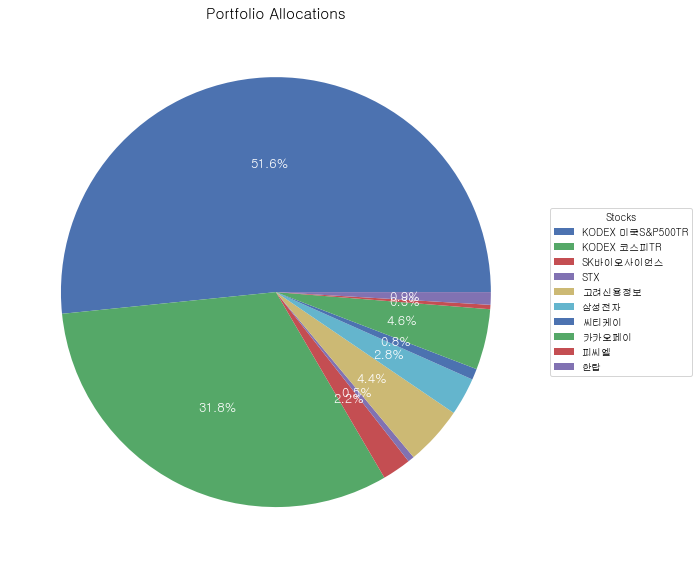

In [798]:
plot_pie(weights_df, save_img_path)

In [819]:
returns, positions = pf_returns, pf_positions

* Write MD file

In [858]:
from mdutils.mdutils import MdUtils
from mdutils.tools.Table import Table
import markdown
from datetime import timedelta, datetime

In [927]:
mdFile = MdUtils(file_name='Example_Markdown',title='HUG-Portfolio Reports')
mdFile.create_md_file()
mdFile.new_line("<br>")

mdFile.new_header(level=1, title='')
start_str = "{year}.{month}.{day}".format(year = start_date.year, month = start_date.month, day = start_date.day)
now_str = "{year}.{month}.{day}".format(year = datetime.now().year, month = datetime.now().month, day = datetime.now().day)
mdFile.new_header(level=2, title='01. Portfolio Allocations ({}~{})'.format(start_str, now_str))
mdFile.new_line("<br>")

mdFile.new_line("최적화된 포트폴리오의 샤프 비율, 시장 베타, 최대 손실폭은 다음과 같다.",bold_italics_code='bold')
mdFile.new_line("<br>")
mdFile.new_line("1. The Sharpe Ratio of the backtest is (샤프 비율): {}".format(np.round(empyrical.sharpe_ratio(pf_returns), 4)))
mdFile.new_line("2. The market beta of the backtest is (시장 베타): {}".format(np.round(empyrical.beta(pf_returns, kospi.pct_change()),4)))
mdFile.new_line("3. The maxmimum drawdown of the backtest is (최대 손실폭): {}".format(np.round(empyrical.max_drawdown(pf_returns), 4)))

mdFile.new_line("<br>")
mdFile.new_line("현재 시점으로 보유 종목의 최적 배분은 다음과 같다.",bold_italics_code='bold')
mdFile.new_header(level=2, title='')

weights_df = pd.DataFrame.from_dict(weights, orient='index', columns=['Allocations'])
weights_df = weights_df.loc[weights_df.Allocations != 0]
weights_df['Balance'] = np.array(pf_positions.tail(1).loc[:, weights_df.index])[0]
append_weights = pd.DataFrame({"Allocations":[0.0], "Balance": [np.array(pf_positions.tail(1)['cash'])[0]]}, index = ['현금'])
weights_df = pd.concat([weights_df, append_weights])
weights_df['Allocations'] = [str(np.round(x,4)) for x in weights_df['Allocations']]
weights_df['Balance'] = [str(np.int(x)) for x in weights_df['Balance']]

mdFile.write(weights_df.to_markdown() + "\n")

mdFile.new_header(level=3, title='')
mdFile.new_header(level=4, title='[표 1] 최적 포트폴리오 배분')
mdFile.new_line("<br>")

mdFile.new_line(mdFile.new_inline_image(text='Portfolio Allocations', path='./datasets/imgs/Portfolio Allocations.png'))

mdFile.new_header(level=4, title='[그림 1] 최적 포트폴리오 배분 파이 차트')
mdFile.new_line("<br>")

mdFile.new_header(level=2, title='02. 포트폴리오 성과 통계량 요약')

mdFile.new_line("<br>")
#mdFile.new_line("포트폴리오 전체 기간에 대한 측정 항목 및 통계량은 다음과 같다.", bold_italics_code='bold')
mdFile.new_line("포트폴리오 전체 기간에 대한 측정 항목 및 통계량은 다음과 같다.")

mdFile.new_header(level=2, title='')
port_summary = get_perf_stats(pf_returns)
port_summary.columns = ['성과 통계량']
temp_idx = ['연간 수익률', '누적 수익률', '연간 변동성', '샤프 비율', '칼마 비율', '안정성', '최대 손실 폭', '오메가 비율', '솔티노 비율', '왜도', '첨도', '테일 비율', '일별 VaR']
port_summary.index = [x+" ({})".format(y) for x,y in zip(temp_idx, port_summary.index)]
mdFile.write(port_summary.to_markdown() + "\n")

mdFile.new_header(level=3, title='')
mdFile.new_header(level=4, title='[표 2] 포트폴리오 성과 통계표')
mdFile.new_line("<br>")

mdFile.new_line(mdFile.new_inline_image(text='Portfolio Summary', path='./datasets/imgs/Portfolio Summary.png'))
mdFile.new_header(level=4, title='[그림 2] 포트폴리오 성과 통계 도표')

mdFile.new_line("<br>")
mdFile.new_header(level=2, title='03. 포트폴리오 백테스팅 결과')
mdFile.new_header(level=3, title='03.1 포트폴리오 Growth & Returns')
mdFile.new_line("<br>")
mdFile.new_line("벤치마크 대비 포트폴리오의 기간 내 성과는 다음과 같다.")
mdFile.new_header(level=2, title='')
mdFile.new_header(level=3, title='')

mdFile.new_line(mdFile.new_inline_image(text='Growth & Return', path='./datasets/imgs/Growth & Return.png'))
mdFile.new_header(level=4, title='[그림 3] 포트폴리오의 기간 내 Growth & Returns')

mdFile.new_line("<br>")
mdFile.new_header(level=3, title='03.2 포트폴리오 월/연도별 Returns')
mdFile.new_line("<br>")
mdFile.new_line("포트폴리오의 연도별 Returns는 다음과 같다.")

mdFile.new_header(level=3, title='')
pf_year = pd.DataFrame(pf.timeseries.aggregate_returns(pf_returns, 'yearly'))
pf_year.index.name = ''
pf_year.columns = ['Return']
mdFile.write(pf_year.to_markdown() + "\n")
mdFile.new_header(level=4, title='[표 3] 연도별 Returns')

mdFile.new_line("<br>")
mdFile.new_line("포트폴리오의 연도별, 월별 Returns를 도식화하면 그림 4와 같으며 좌측 상단부터 시계방향으로 설명하면 다음과 같다.   ", bold_italics_code='bold')
mdFile.new_line("<br>")
mdFile.new_line("1. 연도별 Returns")
mdFile.new_line("2. 월별 Returns의 분포")
mdFile.new_line("3. 연도-월별 Returns의 막대 그래프")
mdFile.new_line("4. 연도-월별 Returns의 히트맵")
mdFile.new_line(" ")

mdFile.new_line(mdFile.new_inline_image(text='Annual Returns', path='./datasets/imgs/Monthly & Annualy Returns.png'))
mdFile.new_header(level=4, title='[그림 4] 월 & 연도별 Returns 도표')
mdFile.new_line("<br>")



mdFile.new_line("<br>")
mdFile.new_header(level=3, title='03.3 포트폴리오 하락 기간과 팩터 노출')
mdFile.new_line("<br>")
mdFile.new_line("해당 포트의 주요 하락 기간은 다음과 같다.")

mdFile.new_header(level=3, title='')
port_ddw = pf.timeseries.gen_drawdown_table(pf_returns, top = 5)
mdFile.write(port_ddw.to_markdown() + "\n")
mdFile.new_header(level=4, title='[표 4] Top 5 하락 기간')

mdFile.new_line("<br>")
mdFile.new_line("포트폴리오의 연도별, 월별 Returns를 도식화하면 그림 4와 같으며 좌측 상단부터 시계방향으로 설명하면 다음과 같다.   ", bold_italics_code='bold')
mdFile.new_line("<br>")
mdFile.new_line("1. Top 5 손실 기간 ")
mdFile.new_line("2. 롤링 포트폴리오 베타")
mdFile.new_line("3. Underwater Plot")
mdFile.new_line("4. 롤링 샤프 비율 (6개월)")
mdFile.new_line(" ")

mdFile.new_line(mdFile.new_inline_image(text='Factor & Drawdown', path='./datasets/imgs/Factor & Drawdown.png'))
mdFile.new_header(level=4, title='[그림 5] 시간 경과에 따른 하락 기간 및 팩터 노출 그래프')
mdFile.new_line("<br>")

In [928]:
mdFile.create_md_file()

markdown.markdownFromFile(
    input='Example_Markdown.md',
    output='Example_Markdown.html',
    extensions=['markdown.extensions.tables'],
    encoding='utf8'
)